<h2><center>MNIST classification using <i>LeNet5</i></center></h2>

# Importing Keras



In [1]:
# Importing the Keras main module relying on tensorflow backend
import tensorflow as tf
import keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.20.0
Using keras version 3.12.0


# Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets
Verify the amount of system memory available before and after loading the dataset.

In [2]:
#@title
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet
from keras.datasets import mnist
# START CODE HERE
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# END CODE HERE

Turn train and test labels to one-hot encoding

In [3]:
# Turning the lables into one-hot format
from keras.utils import to_categorical
# START CODE HERE
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
# END CODE HERE

Reshape train and test images so that they follow the NWHC ordering required by the TF backend. Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation

In [4]:
# Reshaping the images to NWHC scheme
img_rows, img_cols = x_train.shape[1], x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
# START CODE HERE
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# END CODE HERE

# Cast pixels from uint8 to float32
# START CODE HERE
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# END CODE HERE

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
# START CODE HERE
mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
# END CODE HERE

# Defining the neural network architecture (i.e., the network model)
Create a LeNet5-like convolutional neural network taking in input the images as matrices of pixels and suitable to classify each image across 10 different classes.

In [32]:
# The Sequential module is sort of a container for more complex NN elements and
# defines a loop-less NN architecture
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Flatten, Convolution2D, MaxPooling2D

input_shape = (img_rows, img_cols, 1)
output_shape = (10,)

# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (5, 5)
# Number of filters in first convolutional layer
num_kernel_first_conv_layer = 6
# Number of filters in second convolutional layer
num_kernel_second_conv_layer = 16

# START CODE HERE
model_ground = Sequential()
model_ground.add(Convolution2D(num_kernel_first_conv_layer, kernel_size, activation='sigmoid', input_shape=input_shape))
model_ground.add(MaxPooling2D(pool_size=pool_size))
model_ground.add(Convolution2D(num_kernel_second_conv_layer, kernel_size, activation='sigmoid'))
model_ground.add(MaxPooling2D(pool_size=pool_size))
model_ground.add(Flatten())
model_ground.add(Dense(120, activation='sigmoid'))
model_ground.add(Dense(84, activation='sigmoid'))
model_ground.add(Dense(output_shape[0], activation='softmax'))
# END CODE HERE

c:\Users\juann\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Instantiate a SGD optimizer with a tentative LR of 10^-2 and using the appropriate loss function and compile the model.

In [33]:
# The optimizers module provides a number of optimization algorithms for updating
# a netwok parameters accoridng to the computed error gradints
from keras import optimizers

# START CODE HERE
optimizer = optimizers.SGD(learning_rate=10e-2)
model_ground.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# END CODE HERE

# We can now have a look at the defined model topology
model_ground.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 120)            │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,426 (173.54 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

# Training the network - fit()

In [34]:
# This is where the actual training-testing happens
# Dimension of the batch size (number of images over which error gradients are averaged)
batch_size = 20
# Number of epochs we want to train
epochs = 10
history=model_ground.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.4869 - loss: 1.4590 - val_accuracy: 0.9027 - val_loss: 0.3475
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9334 - loss: 0.2285 - val_accuracy: 0.9492 - val_loss: 0.1669
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9592 - loss: 0.1365 - val_accuracy: 0.9685 - val_loss: 0.1051
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9689 - loss: 0.1021 - val_accuracy: 0.9756 - val_loss: 0.0776
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9742 - loss: 0.0846 - val_accuracy: 0.9798 - val_loss: 0.0652
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9774 - loss: 0.0732 - val_accuracy: 0.9778 - val_loss: 0.0695
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9800 - loss: 0.0656 - val_accuracy: 0.9841 - val_loss: 0.0548
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9820 - loss: 0

# Visualizing the network performance
Visualize the training history using the pyplot package: plot in one graph the train and vaidation loss functions, in another graph the train and validation accuracy

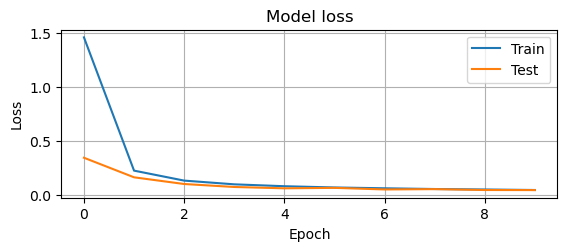

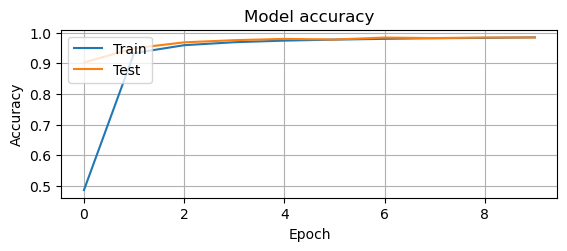

In [35]:
# We now want to plot the train and validation loss functions and accuracy curves
import matplotlib.pyplot as plt
# summarize history for loss
# START CODE HERE
plt.figure()

plt.subplot(2, 1, 1)
plt.grid(visible=True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
# END CODE HERE
plt.show()

# summarize history for accuracy
# START CODE HERE
plt.subplot(2, 1, 2)
plt.grid(visible=True)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# END CODE HERE
plt.show()


# Experiments

Note down the performance of the trained network in terms of training and validation accuracy as a reference. Then, experiment as follow and compare performance with the reference scenario.

*   **Hidden layers activations**: experiment replacing sigmoids with ReLUs.
*   **Filter size**: experiment with (stacks of) square filters of size 3x3 so to obtain equivalent filters 5x5.
*   **Number of filters**: experiment increasing the number of filters in the first and second layer and find the maximum number of filters the network can tolerate before overfitting to the training samples.
* **Pooling-less architectures**: Modify the network architecture to obtain a twofold reduction of each featuremap without resorting to pooling layers (hint: take insipiration from ResNet).
* **Confusion analysis**: Using the proper metric  from sklearn, check which character is most frequently confused with which: can you explain why ?



$$\bold{\text{Solution}}$$

Save the performance of our original CNN:

In [36]:
ground_loss = history.history['val_loss'][-1]
ground_accuracy = history.history['val_accuracy'][-1]

### __Hidden Layers Activations__

In [10]:
pool_size = (2, 2)
kernel_size = (5, 5)
num_kernel_first_conv_layer = 6
num_kernel_second_conv_layer = 16

model = Sequential()
model.add(Convolution2D(num_kernel_first_conv_layer, kernel_size, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(num_kernel_second_conv_layer, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(output_shape[0], activation='softmax'))

optimizer = optimizers.SGD(learning_rate=10e-2)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_hla=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.9522 - loss: 0.1525 - val_accuracy: 0.9839 - val_loss: 0.0500
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9810 - loss: 0.0612 - val_accuracy: 0.9745 - val_loss: 0.0869
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9872 - loss: 0.0434 - val_accuracy: 0.9876 - val_loss: 0.0406
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9885 - loss: 0.0380 - val_accuracy: 0.9871 - val_loss: 0.0436
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9910 - loss: 0.0297 - val_accuracy: 0.9878 - val_loss: 0.0423
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9912 - loss: 0.0284 - val_accuracy: 0.9872 - val_loss: 0.0400
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9925 - loss: 0.0250 - val_accuracy: 0.9870 - val_loss: 0.0461
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9936 - loss: 

In [11]:
hla_loss = history_hla.history['val_loss'][-1]
hla_accuracy = history_hla.history['val_accuracy'][-1]

print(f"The difference of the final validation loss is {ground_loss - hla_loss}")
print(f"The difference of the final validation accuracy is {ground_accuracy - hla_accuracy}")

The difference of the final validation loss is -0.0012398101389408112
The difference of the final validation accuracy is -0.0031000375747680664


We see that the ReLu activations leads to better performance, even if the loss of our new model is higher than that of our ground model, the accuary (is a little) biger.

### __Filter size__

First we do the math: a $5\times5$ kernell has a receptive field of 25 pixels on the image, ($5$ on each direction).We see that with only one $3\times3$ kernell we have a $3$-receptive field on each directions, as we want it to be $5$ we use another layer of conv $3\times3$:  


In [13]:
pool_size = (2, 2)
kernel_size = (3, 3)
num_kernel_first_conv_layer = 6
num_kernel_second_conv_layer = 16

model = Sequential()

model.add(Convolution2D(num_kernel_first_conv_layer, 
                        kernel_size, activation='sigmoid', 
                        input_shape=input_shape,
                        padding='same'))
model.add(Convolution2D(num_kernel_first_conv_layer, 
                        kernel_size, activation='sigmoid'
                        ,padding='same'))

model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(num_kernel_second_conv_layer, 
                        kernel_size, activation='sigmoid',
                        padding='same'))
model.add(Convolution2D(num_kernel_second_conv_layer, 
                        kernel_size, activation='sigmoid',
                        padding='same'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(120, activation='sigmoid'))
model.add(Dense(84, activation='sigmoid'))
model.add(Dense(output_shape[0], activation='softmax'))

optimizer = optimizers.SGD(learning_rate=10e-2)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_fs=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.1032 - loss: 2.3131 - val_accuracy: 0.1032 - val_loss: 2.3029
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.1080 - loss: 2.3039 - val_accuracy: 0.1028 - val_loss: 2.3036
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.1067 - loss: 2.3028 - val_accuracy: 0.1135 - val_loss: 2.3017
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.1090 - loss: 2.3030 - val_accuracy: 0.1135 - val_loss: 2.3020
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.1084 - loss: 2.3026 - val_accuracy: 0.1028 - val_loss: 2.3025
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.1096 - loss: 2.3025 - val_accuracy: 0.1135 - val_loss: 2.3020
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.1096 - loss: 2.3027 - val_accuracy: 0.1135 - val_loss: 2.3029
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.1095 - los

In [14]:
fs_loss = history_fs.history['val_loss'][-1]
fs_accuracy = history_fs.history['val_accuracy'][-1]

print(f"The difference of the final validation loss is {ground_loss - fs_loss}")
print(f"The difference of the final validation accuracy is {ground_accuracy - fs_accuracy}")

The difference of the final validation loss is -2.2559941671788692
The difference of the final validation accuracy is 0.8705999851226807


We see a great difference between the ground model and this new model. Even if we find a "mathematical" equivalent model to the ground one, is difficult that this achives the same performance, for instance we find that the loss of the new model is grater by $2.255$ from that of the ground model. The accuary of our model is greater by $0.87$.

This shows that, even if the models have the same induced perceptive field, they may not be equivalent 

We propose the following function:

In [27]:
def overfiting(num_filters, margin= 10e-3):
    pool_size = (2, 2)
    kernel_size = (5, 5)
    
    num_kernel_first_conv_layer = num_filters
    num_kernel_second_conv_layer = int(num_filters * (16/6))

    model = Sequential()
    model.add(Convolution2D(num_kernel_first_conv_layer, kernel_size, activation='sigmoid', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Convolution2D(num_kernel_second_conv_layer, kernel_size, activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(120, activation='sigmoid'))
    model.add(Dense(84, activation='sigmoid'))
    model.add(Dense(output_shape[0], activation='softmax'))

    optimizer = optimizers.SGD(learning_rate=10e-2)
    model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_of=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    
    train_loss = history_of.history['loss']
    val_loss = history_of.history['val_loss']
    
    val_increasing = False
    if len(val_loss) >= 2:
        val_increasing = all(val_loss[i] < val_loss[i+1] 
                           for i in range(-2, -1))
    
    if  val_increasing or (abs(train_loss[-1] - val_loss[-1]) > margin):
        print(f"Overfiting detected with {num_filters} filters\nLoss diference {train_loss[-1]-val_loss[-1]}")
    else:
        print(f"No overfiting detected with {num_filters} filters\nLoss diference {train_loss[-1]-val_loss[-1]}")

    return history_of


This functions evaluates if a model with a certain number of filters on the first and second convolution layer is overfiting or not with the following criteria:

- The ```validation loss``` has increased in the two last epochs
- The diference betwen the last values of the train loss and validation loss is larger than a certain margin.

Therefore we search a number of filters s.t the curve of validation loss has attained a minimun value and then started increasing

In [18]:
history_nf_8 = overfiting(8, margin=10e-4)

c:\Users\juann\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.4588 - loss: 1.5167 - val_accuracy: 0.9118 - val_loss: 0.3056
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9402 - loss: 0.2035 - val_accuracy: 0.9583 - val_loss: 0.1356
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9640 - loss: 0.1176 - val_accuracy: 0.9747 - val_loss: 0.0846
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.9733 - loss: 0.0876 - val_accuracy: 0.9717 - val_loss: 0.0860
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9780 - loss: 0.0718 - val_accuracy: 0.9813 - val_loss: 0.0594
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9818 - loss: 0.0618 - val_accuracy: 0.9834 - val_loss: 0.0519
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9829 - loss: 0.0551 - val_accuracy: 0.9839 - val_loss: 0.0504
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9846 - loss: 

In [20]:
history_nf_12 = overfiting(12)

c:\Users\juann\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.5337 - loss: 1.3269 - val_accuracy: 0.9255 - val_loss: 0.2540
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9448 - loss: 0.1864 - val_accuracy: 0.9647 - val_loss: 0.1179
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9678 - loss: 0.1082 - val_accuracy: 0.9737 - val_loss: 0.0809
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9760 - loss: 0.0809 - val_accuracy: 0.9810 - val_loss: 0.0631
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9791 - loss: 0.0662 - val_accuracy: 0.9829 - val_loss: 0.0557
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9829 - loss: 0.0567 - val_accuracy: 0.9853 - val_loss: 0.0459
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9855 - loss: 0.0496 - val_accuracy: 0.9855 - val_loss: 0.0447
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9870 - loss: 0

In [21]:
history_nf_16 = overfiting(16)

c:\Users\juann\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.5029 - loss: 1.3931 - val_accuracy: 0.9208 - val_loss: 0.2670
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9463 - loss: 0.1828 - val_accuracy: 0.9580 - val_loss: 0.1256
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.9688 - loss: 0.1025 - val_accuracy: 0.9734 - val_loss: 0.0832
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9767 - loss: 0.0768 - val_accuracy: 0.9809 - val_loss: 0.0659
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9811 - loss: 0.0635 - val_accuracy: 0.9837 - val_loss: 0.0534
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9836 - loss: 0.0543 - val_accuracy: 0.9788 - val_loss: 0.0597
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9859 - loss: 0.0472 - val_accuracy: 0.9860 - val_loss: 0.0413
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9876 - lo

In [25]:
history_nf_18 = overfiting(18)

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.5433 - loss: 1.2982 - val_accuracy: 0.9224 - val_loss: 0.2633
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9472 - loss: 0.1775 - val_accuracy: 0.9691 - val_loss: 0.1014
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9703 - loss: 0.0987 - val_accuracy: 0.9785 - val_loss: 0.0698
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - accuracy: 0.9774 - loss: 0.0732 - val_accuracy: 0.9832 - val_loss: 0.0552
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.9820 - loss: 0.0592 - val_accuracy: 0.9849 - val_loss: 0.0487
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - accuracy: 0.9845 - loss: 0.0506 - val_accuracy: 0.9865 - val_loss: 0.0420
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.9872 - loss: 0.0435 - val_accuracy: 0.9870 - val_loss: 0.0382
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9879 - 

In [28]:
history_nf_20 = overfiting(20)

c:\Users\juann\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - accuracy: 0.5567 - loss: 1.2573 - val_accuracy: 0.9248 - val_loss: 0.2415
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9506 - loss: 0.1654 - val_accuracy: 0.9687 - val_loss: 0.1048
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.9710 - loss: 0.0971 - val_accuracy: 0.9708 - val_loss: 0.0898
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9774 - loss: 0.0736 - val_accuracy: 0.9814 - val_loss: 0.0602
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9822 - loss: 0.0599 - val_accuracy: 0.9841 - val_loss: 0.0506
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.9844 - loss: 0.0515 - val_accuracy: 0.9826 - val_loss: 0.0554
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9864 - loss: 0.0449 - val_accuracy: 0.9876 - val_loss: 0.0387
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9877 -

We found overfiting with $20$ filters on the first layer and $48$ on the second one

### __Pooling-less architectures__

Instead of pooling we may use a ```stride = 2```:

In [29]:
model = Sequential()
model.add(Convolution2D(6, (3,3), strides=2, padding='same', 
                 activation='sigmoid', input_shape=input_shape))
model.add(Convolution2D(6, (3,3), strides=2, padding='same', activation='sigmoid'))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu')) 
model.add(Dense(output_shape[0], activation='softmax'))

optimizer = optimizers.SGD(learning_rate=10e-2)

model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_wopol=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

c:\Users\juann\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7189 - loss: 0.7836 - val_accuracy: 0.9402 - val_loss: 0.1831
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9513 - loss: 0.1552 - val_accuracy: 0.9633 - val_loss: 0.1125
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9652 - loss: 0.1106 - val_accuracy: 0.9683 - val_loss: 0.1017
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9717 - loss: 0.0868 - val_accuracy: 0.9725 - val_loss: 0.0879
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9771 - loss: 0.0718 - val_accuracy: 0.9778 - val_loss: 0.0728
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9803 - loss: 0.0613 - val_accuracy: 0.9778 - val_loss: 0.0722
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9833 - loss: 0.0530 - val_accuracy: 0.9772 - val_loss: 0.0750
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9853 - loss: 0

In [30]:
np_loss = history_wopol.history['val_loss'][-1]
np_accuracy = history_wopol.history['val_accuracy'][-1]

print(f"Validation loss diference without pooling layers: {ground_loss-np_loss}")
print(f"Validation accuracy diference without pooling layers: {ground_accuracy - np_accuracy}")

Validation loss diference without pooling layers: -0.02124984934926033
Validation accuracy diference without pooling layers: 0.0045999884605407715


We conclude that the loss of our ground model us less than that of our no-pooling model. Therefore this model is (a little) worst than the original. This is confirmed by the accuary, being that of our ground model higher. 

### __Confusion analysis__

In [37]:
# Example of a confusion matrix using sklearn.metrics
from sklearn.metrics import confusion_matrix
predictions = model_ground.predict(x_test)
# START CODE HERE
matrix = confusion_matrix(y_test.argmax(axis=1),
                          predictions.argmax(axis=1))
# END CODE HERE
print (matrix)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[[ 969    0    2    1    0    0    5    1    2    0]
 [   0 1128    1    2    0    0    2    1    1    0]
 [   1    1 1023    2    2    0    1    1    1    0]
 [   1    0    1 1002    0    3    0    1    2    0]
 [   0    0    1    0  978    0    2    0    0    1]
 [   2    0    0   12    0  873    2    1    0    2]
 [   1    3    0    1    3    6  944    0    0    0]
 [   0    3   11    8    0    0    0 1000    0    6]
 [   4    0    2    5    2    2    1    2  949    7]
 [   2    3    0    7    9    4    0    5    1  978]]


We can see that on our ground model all the clases are almost perfectly clasified safe some examples:

- There are a few samples from the number $0$ that are classifeid as a $6$
- $12$ samples from number $5$ were classified as $3$
- $11$ samples from number $7$ were classifed as $2$ and $6$ as a $9$

This is explained by the fact that, as can be view in the previous phrases, this pairs of numbers ($(0,6)$,$(5,3)$,$(7,2)$ and $(7,9)$) are very similar (in the visual sense), leading to confution to a visual recognition model as this one

# Saving the training results

Save the best trained model (topology, parameters), and all the related side information required to deploy the trained model later on.

We make the following recapitulative dict:

In [41]:
models = {"ground":(history, ground_loss, ground_accuracy),
          "hla":(history_hla, hla_loss, hla_accuracy),
          "fs": (history_fs, fs_loss, fs_accuracy),
          "wopol": (history_wopol, np_loss, np_accuracy),
          "8 filters": (history_nf_8, history_nf_8.history["val_loss"][-1], history_nf_8.history["val_accuracy"][-1]),
          "12 filters": (history_nf_12, history_nf_12.history["val_loss"][-1], history_nf_12.history["val_accuracy"][-1]),
          "16 filters": (history_nf_16, history_nf_16.history["val_loss"][-1], history_nf_16.history["val_accuracy"][-1]),
          "18 filters": (history_nf_18, history_nf_18.history["val_loss"][-1], history_nf_18.history["val_accuracy"][-1]),
          "20 filters": (history_nf_20, history_nf_20.history["val_loss"][-1], history_nf_20.history["val_accuracy"][-1])}

We visualice the models and find the best model:

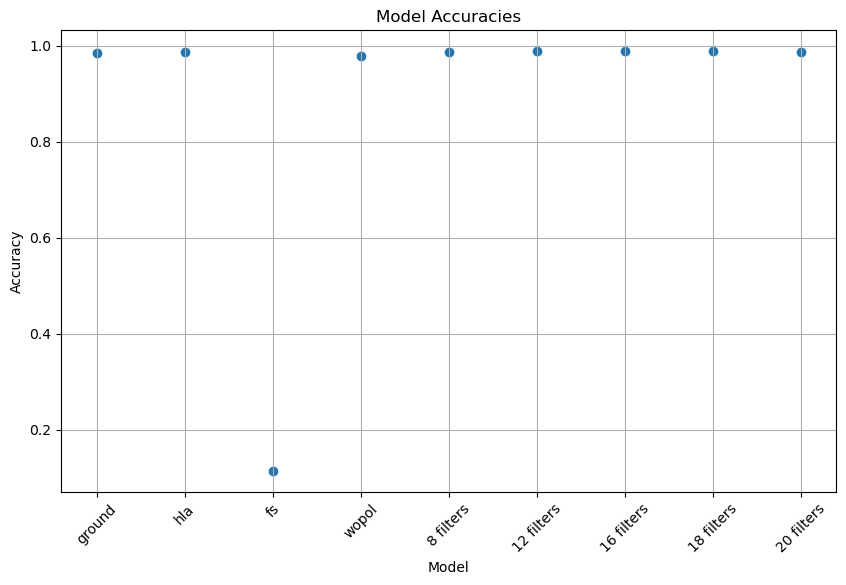

In [46]:
accuaries = [models[key][2] for key in models.keys()]
plt.figure(figsize=(10, 6))
plt.scatter(models.keys(), accuaries)
plt.grid(visible=True)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.xticks(rotation=45)
plt.show()

In [48]:
best_model = max(models, key=lambda key: models[key][2])
print(f"The best model is {best_model} with accuracy {models[best_model][2]}")

The best model is 18 filters with accuracy 0.9887999892234802


In [49]:
pool_size = (2, 2)
kernel_size = (5, 5)
    
num_kernel_first_conv_layer = 18
num_kernel_second_conv_layer = int(18 * (16/6))

model = Sequential()
model.add(Convolution2D(num_kernel_first_conv_layer, kernel_size, activation='sigmoid', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(num_kernel_second_conv_layer, kernel_size, activation='sigmoid'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(120, activation='sigmoid'))
model.add(Dense(84, activation='sigmoid'))
model.add(Dense(output_shape[0], activation='softmax'))

optimizer = optimizers.SGD(learning_rate=10e-2)
model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_of=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

c:\Users\juann\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.4953 - loss: 1.4242 - val_accuracy: 0.9164 - val_loss: 0.2872
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.9425 - loss: 0.1930 - val_accuracy: 0.9657 - val_loss: 0.1144
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9695 - loss: 0.1020 - val_accuracy: 0.9770 - val_loss: 0.0751
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9779 - loss: 0.0737 - val_accuracy: 0.9842 - val_loss: 0.0519
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9816 - loss: 0.0602 - val_accuracy: 0.9853 - val_loss: 0.0491
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.9850 - loss: 0.0509 - val_accuracy: 0.9852 - val_loss: 0.0426
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9865 - loss: 0.0446 - val_accuracy: 0.9863 - val_loss: 0.0424
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9882 - l

In [51]:
# Create a directory for saving both the trained model and side information
import os
save_dir = os.path.join(os.getcwd(), 'trained_lenet5_mnist')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# Save model and weights
# START CODE HERE
model_path = os.path.join(save_dir, 'lenet5_mnist_model.h5')
model.save(model_path)

weights_path = os.path.join(save_dir, 'lenet5_mnist.weights.h5')
model.save_weights(weights_path)

model_json = model.to_json()
json_path = os.path.join(save_dir, 'model_architecture.json')
with open(json_path, 'w') as json_file:
    json_file.write(model_json)
# END CODE HERE
print('Saved trained model at %s ' % model_path)

# Saving mean and standard deviation information as a CSV file
import csv
# START CODE HERE
x_train_mean = x_train.mean()
x_train_std = x_train.std()
stats_path = os.path.join(save_dir, 'training_statistics.csv')
with open(stats_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Parameter', 'Value'])
    writer.writerow(['x_train_mean', x_train_mean])
    writer.writerow(['x_train_std', x_train_std])
    writer.writerow(['input_shape', input_shape])
    writer.writerow(['output_shape', output_shape[0]])
    writer.writerow(['num_kernel_first_conv_layer', num_kernel_first_conv_layer])
    writer.writerow(['num_kernel_second_conv_layer', num_kernel_second_conv_layer])
    writer.writerow(['kernel_size', kernel_size])
    writer.writerow(['pool_size', pool_size])
    writer.writerow(['batch_size', batch_size])
    writer.writerow(['epochs', epochs])
    writer.writerow(['final_train_accuracy', history_of.history['accuracy'][-1]])
    writer.writerow(['final_val_accuracy', history_of.history['val_accuracy'][-1]])
    writer.writerow(['final_train_loss', history_of.history['loss'][-1]])
    writer.writerow(['final_val_loss', history_of.history['val_loss'][-1]])

history_path = os.path.join(save_dir, 'training_history.csv')
with open(history_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write header
    headers = ['epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
    writer.writerow(headers)
    # Write data for each epoch
    for epoch in range(len(history_of.history['loss'])):
        row = [
            epoch + 1,
            history_of.history['loss'][epoch],
            history_of.history['accuracy'][epoch],
            history_of.history['val_loss'][epoch],
            history_of.history['val_accuracy'][epoch]
        ]
        writer.writerow(row)

optimizer_config = optimizer.get_config()
config_path = os.path.join(save_dir, 'optimizer_config.csv')
with open(config_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Parameter', 'Value'])
    for key, value in optimizer_config.items():
        writer.writerow([key, value])
# END CODE HERE
print('Saved side information at %s ' % stats_path)

Saved trained model at c:\Users\juann\AthensWeekLabs\Lab2\trained_lenet5_mnist\lenet5_mnist_model.h5 
Saved side information at c:\Users\juann\AthensWeekLabs\Lab2\trained_lenet5_mnist\training_statistics.csv 
